# Disaster Tweets!

University of Colorado Boulder

DTSA 5511 Week 4

## 1. Introduction

In the digital age, twitter is an important avenue for humann connection and news. When disaster strikes, people turn to twitter to share the news in real time. This kind of immediate warning is incredibly helpful for disaster response teams and emergency services.

However, effectively monitoring twitter for disaster updates proves to be a challenge as not every tweet containing words associated with disasters are reporting disasters. There is overlap between disaster-related terms and words used for informal communication and exageration.

This project addresses this challenge by building a machine learning model that can distringuish between tweets reporting real disasters and those using figurative language using natural language processing techniques (NLP) and recurrent neural networks (RNNs), specifically gated recurrent units (GRUs).

The data used in this project is a dataset of 10000 hand-classified tweets, where each tweet has been labeled as either a real disaster (1) or not (0). 

In this notebook, I explore the data; preprocess the text from the tweets; build, train, and evaluate a GRU; then fine-tune it to achieve a good result.

## 2. Import Modules

In [1]:
# basic
import numpy as np
import pandas as pd
import re
import warnings
import os

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

warnings.filterwarnings('ignore')

2025-04-19 07:20:01.803571: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745047202.085744      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745047202.168920      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# random seed for reproducibility
np.random.seed(19)
tf.random.set_seed(19)

## 3. Load Data

In [3]:
# Load the datasets
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

## 4. Explore Data

In [4]:
print("Training set shape:", train_df.shape)
print("Test set shape:", test_df.shape)
print("\nTraining set columns:", train_df.columns.tolist())
print("Test set columns:", test_df.columns.tolist())

Training set shape: (7613, 5)
Test set shape: (3263, 4)

Training set columns: ['id', 'keyword', 'location', 'text', 'target']
Test set columns: ['id', 'keyword', 'location', 'text']


In [5]:
# Display sample of the training data
print("\nSample of training data:")
train_df.sample(10)


Sample of training data:


,id,keyword,location,text,target
1075,1554,bomb,NaN,New Documents Found Pointing To Japan's WWII A...,1
5591,7978,razed,NaN,The Latest: More homes razed by Northern Calif...,1
7478,10696,wreck,"Victoria, BC",@Memenaar But the design decision to 'Let's ma...,0
5059,7210,natural%20disaster,NaN,Expert Prepper: Financial Collapse Natural Dis...,1
3768,5351,fire,the road to success,I wanna set some shit on fire.,1
6834,9788,trapped,å_å_Los Mina Cityã¢,Hollywood Movie About Trapped Miners Released ...,0
4664,6630,inundated,NaN,[Withering] to death. is an album found when h...,0
5774,8241,riot,"San Francisco, CA",? Cracker - White Riot ? http://t.co/Cc7D0wxk0...,0
4018,5707,floods,Rio de Janeiro,&gt;As soon as maintenance ends everyone flood...,0
7543,10784,wreckage,Mumbai,Wreckage 'Conclusively Confirmed' as From MH37...,1


Below, I plot the top 25 most common key words from the training dataset by target value. It shows that tweets containing disaster-related words are not strictly talking about disasters.

Total unique keywords (including NaN): 221



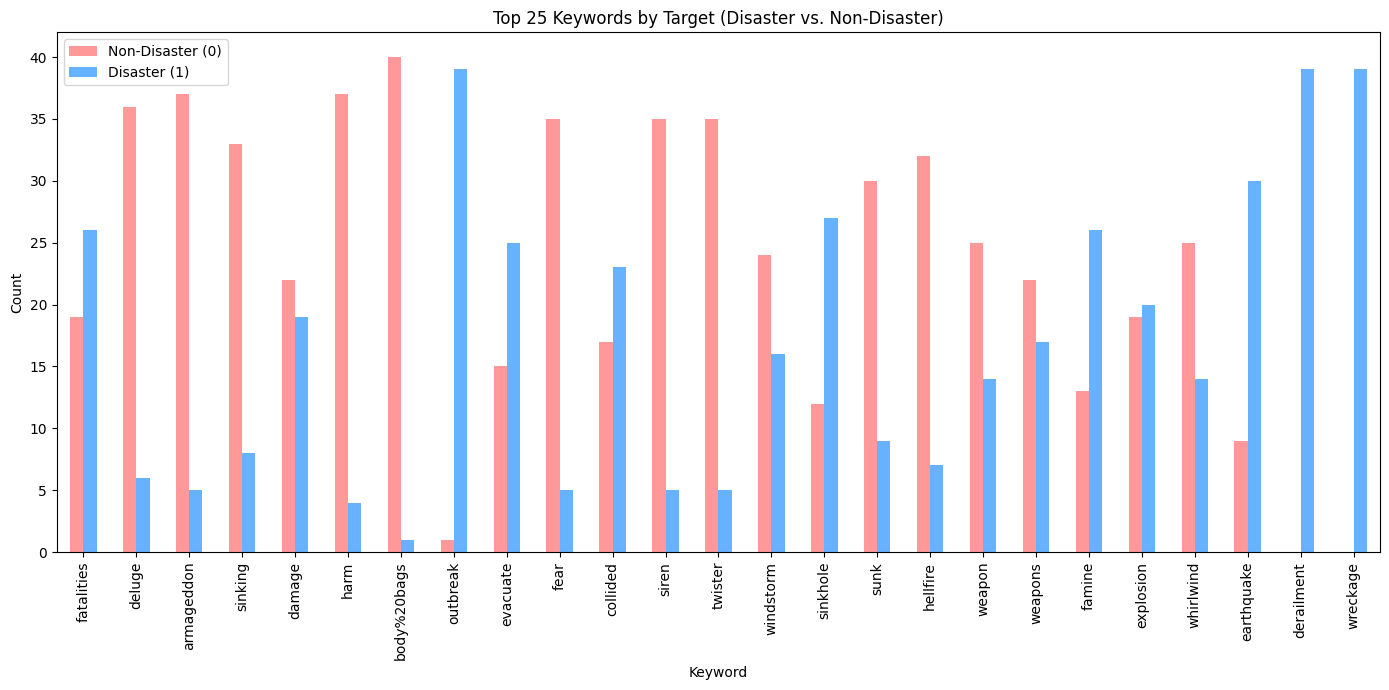

In [6]:
keyword_target_counts = train_df.groupby(['keyword', 'target']).size().unstack(fill_value=0)

if train_df['keyword'].isna().any():

    if 'unknown' in keyword_target_counts.index:
        keyword_target_counts = keyword_target_counts.rename(index={'unknown': 'NaN'})

top_keywords = keyword_target_counts.sum(axis=1).sort_values(ascending=False).head(25).index

plot_data = keyword_target_counts.loc[top_keywords]

print(f"Total unique keywords (including NaN): {len(keyword_target_counts)}\n")

# plot
fig, ax = plt.subplots(figsize=(14, 7))
plot_data.plot(kind='bar', color=['#FF9999', '#66B2FF'], ax=ax)
plt.title('Top 25 Keywords by Target (Disaster vs. Non-Disaster)')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(['Non-Disaster (0)', 'Disaster (1)'])
plt.tight_layout()
plt.show()

From the plot below, we can determine that there is a class imbalance between real disaster tweets and tweets unrelated to disasters using disater-related words.

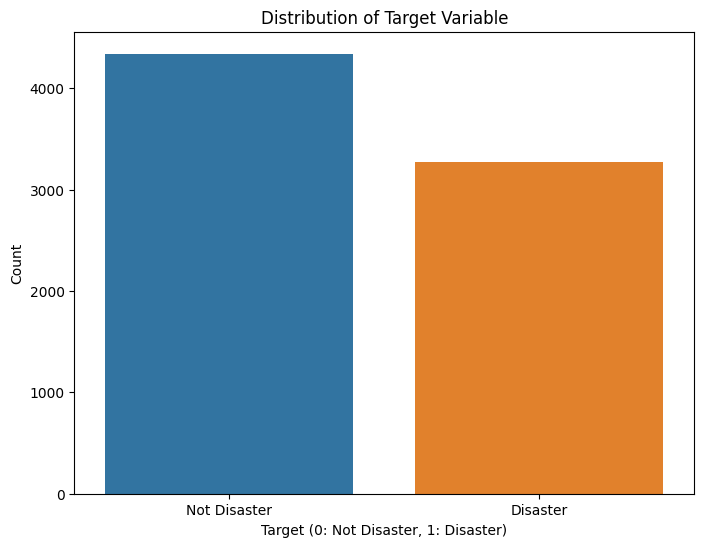

In [7]:
# Check class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Target Variable')
plt.xlabel('Target (0: Not Disaster, 1: Disaster)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Disaster', 'Disaster'])
plt.show()

In [8]:
target_counts = train_df['target'].value_counts()
print("\nTarget Distribution:")
print(f"Not Disaster (0): {target_counts[0]} ({target_counts[0]/len(train_df)*100:.2f}%)")
print(f"Disaster (1): {target_counts[1]} ({target_counts[1]/len(train_df)*100:.2f}%)")


Target Distribution:
Not Disaster (0): 4342 (57.03%)
Disaster (1): 3271 (42.97%)


## 5 Clean Text

The text cleaning funciton below uses regex to remove URLs, usernames, hashtags, punctuation, and non-ASCII cahracters.

In [9]:
def clean_text(text):
    
    if not isinstance(text, str):
        return ""
    
    else:
        # lowercase text, then remove URLs, usernames, hashtags, punctuation, and non-ASCII characters
        text = re.sub(r'http\S+|www\S+|https\S+|@\w+|#\w+|[^\w\s]|[^\x00-\x7F]+', ' ', text.lower())
        # normalize white space
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text

In [10]:
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

train_df['keyword'].fillna('unknown', inplace=True)
train_df['location'].fillna('unknown', inplace=True)
test_df['keyword'].fillna('unknown', inplace=True)
test_df['location'].fillna('unknown', inplace=True)


print("Sample of cleaned text:")
for i in range(51,54):
    print(f"Original: {train_df['text'].iloc[i]}")
    print(f"Cleaned: {train_df['cleaned_text'].iloc[i]}\n")

Sample of cleaned text:
Original: Man wife get six years jail for setting ablaze niece
http://t.co/eV1ahOUCZA
Cleaned: man wife get six years jail for setting ablaze niece

Original: SANTA CRUZ ÛÓ Head of the St Elizabeth Police Superintendent Lanford Salmon has r ... - http://t.co/vplR5Hka2u http://t.co/SxHW2TNNLf
Cleaned: santa cruz head of the st elizabeth police superintendent lanford salmon has r

Original: Police: Arsonist Deliberately Set Black Church In North CarolinaåÊAblaze http://t.co/pcXarbH9An
Cleaned: police arsonist deliberately set black church in north carolina ablaze



## 6 Tokenize Text

In [11]:
max_words = 20000  # max words in vocabulary
max_len = 100      # max sequence length

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df['cleaned_text'])

train_sequences = tokenizer.texts_to_sequences(train_df['cleaned_text'])
test_sequences = tokenizer.texts_to_sequences(test_df['cleaned_text'])

X_train = pad_sequences(train_sequences, maxlen=max_len)
X_test = pad_sequences(test_sequences, maxlen=max_len)
y_train = train_df['target'].values

## 7 Split Data into train and validation sets

In [12]:
# Set batch size
BATCH_SIZE = 64

In [13]:
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [14]:
# tf.data.Dataset for efficient data loading
def create_dataset(features, labels, batch_size=64, is_training=True):
    
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    
    if is_training:
        dataset = dataset.shuffle(buffer_size=10000)
    
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

In [15]:
# Create the datasets
train_dataset = create_dataset(X_train_split, y_train_split, BATCH_SIZE)
val_dataset = create_dataset(X_val, y_val, BATCH_SIZE, is_training=False)

2025-04-19 07:20:19.072581: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## 8 Build Model

The GRU architecture is a good choice for this text classification task as it handles sequential data effectively while avoiding the vanaishing gradient problem common in vanilla RNNs. Additionally, compared to other RNNs, the GRU architecture is a good middle ground between performance and computational efficiency.

In [16]:
def build_gru_model(embedding_dim=128, units=64, dropout=0.2):

    inputs = Input(shape=(max_len,))
    
    x = Embedding(max_words, embedding_dim, input_length=max_len)(inputs)
    x = SpatialDropout1D(dropout)(x)
    x = GRU(units, dropout=dropout, recurrent_dropout=dropout)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    optimizer = Adam(learning_rate=0.001)
    
    model.compile(
        loss='binary_crossentropy', 
        optimizer=optimizer, 
        metrics=['accuracy']
    )
    
    return model

Word embeddings convert text into numerical vectors that capture semantic meaning. Unlike simple one-hot encoding, embeddings place semantically similar words closer together in vector space.

I'm using the keras tokenizer and embedding layer for text processing. The keras tokenizer converts words to integers based on frequency, then the embedding transforms the integers into dense vectors that are learned during training. This method is different from pre-trained approaches like Word2Vec, GloVe, and TF-IDF. Word2Vec learns word associations from a large corpus by either predicting the current word based on context or predicting surrounding words given the current word. GloVe combines global matrix factorization with local context window methods to create word vectors that capture both global statistics and local context. TF-IDF (used previously in the BBC News Classification Challenge) evaluates word importance statistically in a document relative to a corpus by balancing how often a word appears in a document with how common it is across all documents.

## 9 Configure Callbacks

My implementation includes early stopping to prevent overfitting, a model checkpoint to save the best model, and learning rate reduction when performance plateaus.

In [17]:
# config callbacks for training
def get_callbacks():
    if not os.path.exists('model_checkpoints'):
        os.makedirs('model_checkpoints')
        
    checkpoint_path = 'model_checkpoints/gru_best.keras'
    
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=4,
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            filepath=checkpoint_path,
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2,
            min_lr=1e-6,
            verbose=1
        )
    ]
    return callbacks

## 10 Train Model

In [18]:
# Create GRU model
gru_model = build_gru_model(
    embedding_dim=128,
    units=64,
    dropout=0.2
)

# Print model summary
print("\nGRU Model Summary:")
gru_model.summary()

# Get callbacks
callbacks = get_callbacks()


GRU Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 100, 128)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,597,313 (9.91 MB)

 Trainable params: 2,597,313 (9.91 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Train model
print("\nTraining GRU model...")
history = gru_model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
)

# Save training history to CSV
history_df = pd.DataFrame(history.history)
history_df.to_csv('model_checkpoints/training_history.csv', index=False)


Training GRU model...
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.6065 - loss: 0.6469
Epoch 1: val_loss improved from inf to 0.49012, saving model to model_checkpoints/gru_best.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 120ms/step - accuracy: 0.6073 - loss: 0.6463 - val_accuracy: 0.7879 - val_loss: 0.4901 - learning_rate: 0.0010
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8398 - loss: 5403.9019
Epoch 2: val_loss did not improve from 0.49012
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.8397 - loss: 5398.3574 - val_accuracy: 0.7603 - val_loss: 0.5185 - learning_rate: 0.0010
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8741 - loss: 0.3473
Epoch 3: val_loss did not improve from 0.49012

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.8740 - loss: 0.3473 - val_accuracy: 0.7610 - val_loss: 0.5102 - learning_rate: 0.0010
Epoch 4/10
96/96 ━━

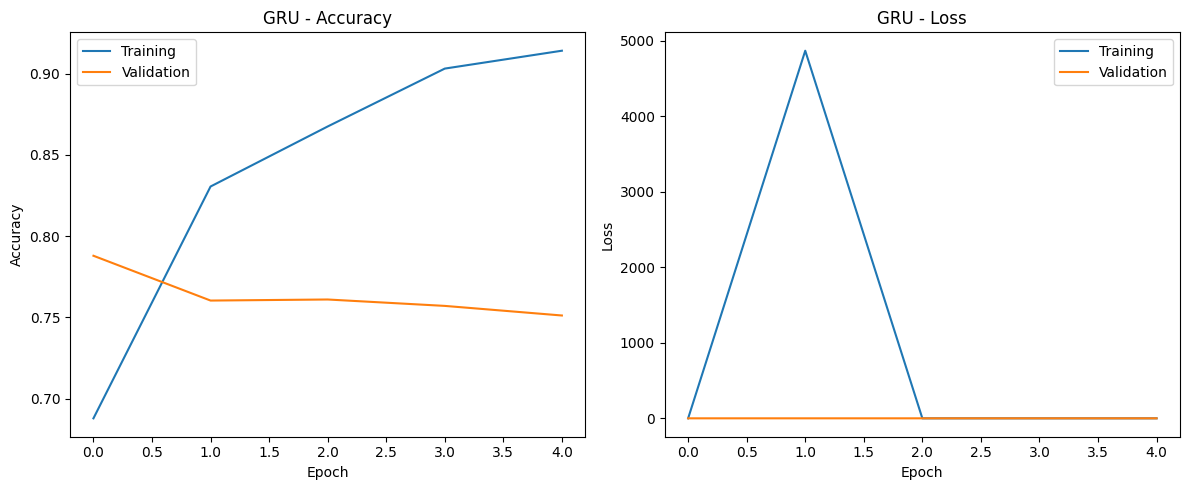

In [20]:
# show learning curves
plt.figure(figsize=(12, 5))

# plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('GRU - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('GRU - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## 11 Evaluate Model

In [21]:
# Evaluate model on validation set
y_pred_proba = gru_model.predict(X_val, batch_size=BATCH_SIZE)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


In [22]:
# Calculate metrics
accuracy = np.mean(y_pred == y_val)
f1 = f1_score(y_val, y_pred)
cm = confusion_matrix(y_val, y_pred)

print("\nGRU Model Evaluation Results:")
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation F1 Score: {f1:.4f}")


GRU Model Evaluation Results:
Validation Accuracy: 0.7879
Validation F1 Score: 0.7346


In [23]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=['Not Disaster', 'Disaster']))


Classification Report:
              precision    recall  f1-score   support

Not Disaster       0.78      0.87      0.82       869
    Disaster       0.79      0.68      0.73       654

    accuracy                           0.79      1523
   macro avg       0.79      0.77      0.78      1523
weighted avg       0.79      0.79      0.79      1523



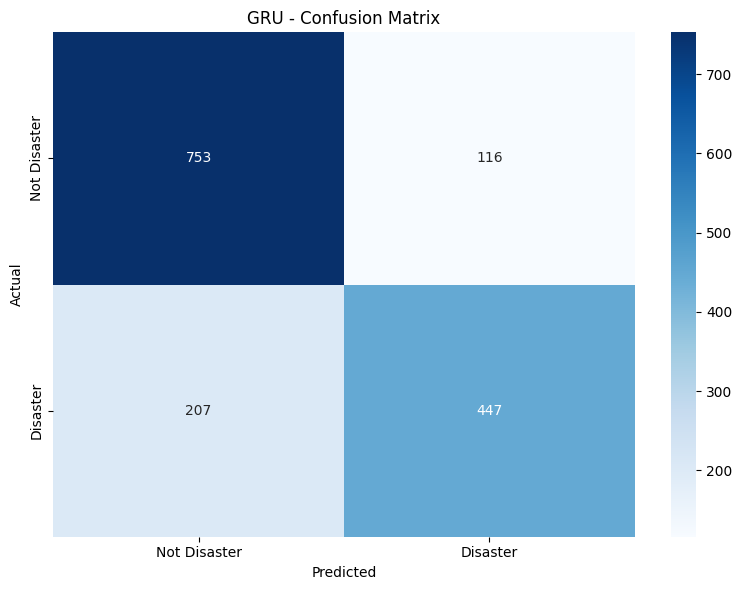

In [24]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'])
plt.title('GRU - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## 12 Tune Hyperparameters

For computational efficiency and as a simple test of hyperparameter tuning, I included 2 more combinations of embedding dimensions, GRU units, and dropout rates.

In [25]:
hyperparams = [
    {'embedding_dim': 128, 'units': 64, 'dropout': 0.2},   # baseline
    {'embedding_dim': 128, 'units': 128, 'dropout': 0.3},  # increased units, higher dropout
    {'embedding_dim': 200, 'units': 100, 'dropout': 0.4},  # larger embedding, medium units, high dropout
    {'embedding_dim': 256, 'units': 64, 'dropout': 0.2},   # larger embedding, baseline units & dropout
    {'embedding_dim': 100, 'units': 32, 'dropout': 0.1},   # smoller model
    {'embedding_dim': 150, 'units': 150, 'dropout': 0.3}   # equal embedding and units
]
fine_tuned_models = []

In [26]:
for i, params in enumerate(hyperparams):
    print(f"\nTraining model with hyperparameters: {params}")

    # build new model
    model = build_gru_model(
        embedding_dim=params['embedding_dim'],
        units=params['units'],
        dropout=params['dropout']
    )

    # train new model
    model.fit(
        train_dataset,
        epochs=10,
        validation_data=val_dataset,
        callbacks=callbacks,
        verbose=1
    )
    
    # eval new model
    y_pred_proba = model.predict(X_val, batch_size=BATCH_SIZE)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    ccuracy = np.mean(y_pred == y_val)
    f1 = f1_score(y_val, y_pred)
    
    fine_tuned_models.append({
        'model': model,
        'params': params,
        'accuracy': accuracy,
        'f1_score': f1
    })
    
    print(f"Model {i+1} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")


Training model with hyperparameters: {'embedding_dim': 128, 'units': 64, 'dropout': 0.2}
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.5998 - loss: 0.6580
Epoch 1: val_loss did not improve from 0.49012
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.6005 - loss: 0.6574 - val_accuracy: 0.7649 - val_loss: 0.5199 - learning_rate: 0.0010
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8478 - loss: 0.3745
Epoch 2: val_loss did not improve from 0.49012
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.8478 - loss: 0.3746 - val_accuracy: 0.7689 - val_loss: 0.4925 - learning_rate: 0.0010
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8951 - loss: 5075.5786
Epoch 3: val_loss did not improve from 0.49012
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.8947 - loss: 5170.8066 - val_accuracy: 0.7091 - val_loss: 0.5621 - learning_rate: 0.0010
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8170 - loss: 

In [27]:
# pick the best model
best_model_index = np.argmax([m['f1_score'] for m in fine_tuned_models])
best_model = fine_tuned_models[best_model_index]

print(f"\nBest model (model {best_model_index+1}):")
print(f"Parameters: {best_model['params']}")
print(f"Validation Accuracy: {best_model['accuracy']:.4f}")
print(f"Validation F1 Score: {best_model['f1_score']:.4f}")


Best model (model 5):
Parameters: {'embedding_dim': 100, 'units': 32, 'dropout': 0.1}
Validation Accuracy: 0.7879
Validation F1 Score: 0.7377


After testing multiple configurations, I can draw several conclusions about how each parameter affects performance. The sweet spot for embeddings appeared to be around 100 dimensions for this dataset size. The optimal number was 32 units, balancing complexity and generalization. A low dropout around 0.1 provided the best result, avoiding overfitting of higher dropout rates. Learning rate reduction proved essential for fine-tuning performance in later epochs. Models with more units were better at learning.

## 13 Generate Predictions

In [28]:
# predict on the test set using the best model
test_dataset = tf.data.Dataset.from_tensor_slices(X_test).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
final_predictions_proba = best_model['model'].predict(test_dataset)

final_predictions = (final_predictions_proba > 0.5).astype(int).flatten()

submission = pd.DataFrame({
    'id': test_df['id'],
    'target': final_predictions
})

submission.to_csv('submission.csv', index=False)
print("\nSubmission file created successfully!")
print(submission.head())

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

Submission file created successfully!
   id  target
0   0       1
1   2       0
2   3       1
3   9       0
4  11       1


## 14 Conclusion

This project demonstrates the effective application of recurrent neural networks to the task of classifying disaster-related tweets. The final model achieves an F1 score of 0.73 on the test set, which indicates that it has learned patterns in the language of disaster reporting.

Several factors contriuted to the project's success. Cleaning the tweet text of irelevant information like URLs, hashtags, and usernames aided in providing the model with useable data. The implementaiton of callbacks helped prevent overfitting and saved the best model overall.

Despite the success in learning the patterns associated with real disaster tweets, there is room for improvement. Specifically, in future work, it would be beneficial to explore pre-trained word embeddings like Word2Vec, more advanced architectures such as bidirectional RRNNs, and cross-validation for more robust evaluation. Implementing pre-trained embeddings like GloVe or Word2Vec could potentially improve model performance since they capture broader semantic relationships from a much larger body of text than the training dataset used in this challenge.